In [103]:
import pandas as pd
import numpy as np
import json
import statsapi
from tqdm.notebook import tqdm
import statistics
import datetime
import matplotlib.pyplot as plt


In [2]:
sched = statsapi.schedule(start_date='2020-03-23', end_date='2020-12-31',)
print(f"num games: {len(sched)}")

num games: 2431


In [109]:
sched_df = pd.DataFrame.from_records(sched)
sched_df["game_datetime_obj"] = sched_df.game_date.map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
sched_df.head()

,game_id,game_datetime,game_date,game_type,status,away_name,home_name,away_id,home_id,doubleheader,...,home_probable_pitcher,away_probable_pitcher,home_pitcher_note,away_pitcher_note,away_score,home_score,current_inning,inning_state,summary,game_datetime_obj
0,605422,2020-03-26T17:10:00Z,2020-03-26,R,Postponed,Washington Nationals,New York Mets,120,121,N,...,,,,,0,0,,,2020-03-26 - Washington Nationals @ New York M...,2020-03-26
1,604457,2020-03-26T17:10:00Z,2020-03-26,R,Postponed,Detroit Tigers,Cleveland Indians,116,114,N,...,,,,,0,0,,,2020-03-26 - Detroit Tigers @ Cleveland Indian...,2020-03-26
2,604265,2020-03-26T18:10:00Z,2020-03-26,R,Postponed,Kansas City Royals,Chicago White Sox,118,145,N,...,,,,,0,0,,,2020-03-26 - Kansas City Royals @ Chicago Whit...,2020-03-26
3,605229,2020-03-26T18:10:00Z,2020-03-26,R,Postponed,Chicago Cubs,Milwaukee Brewers,112,158,N,...,,,,,0,0,,,2020-03-26 - Chicago Cubs @ Milwaukee Brewers ...,2020-03-26
4,603974,2020-03-26T19:05:00Z,2020-03-26,R,Postponed,New York Yankees,Baltimore Orioles,147,110,N,...,,,,,0,0,,,2020-03-26 - New York Yankees @ Baltimore Orio...,2020-03-26


In [4]:
all_teams = set(g['home_name'] for g in sched if not 'all-stars' in g['home_name'].lower())

In [267]:
## from fangraphs -- a few slight tweaks to get initial playoff probabilites aligned
vegas_wins = {
    'Los Angeles Angels': 83,
    'Houston Astros': 97,
    'Oakland Athletics': 88,
    'Toronto Blue Jays': 75,
    'Atlanta Braves': 87,
    'Milwaukee Brewers': 81,
    'St. Louis Cardinals': 80,
    'Chicago Cubs': 85,
    'Arizona Diamondbacks': 79,
    'Los Angeles Dodgers': 100,
    'San Francisco Giants': 69,
    'Cleveland Indians': 87,
    'Seattle Mariners': 65,
    'Miami Marlins': 67,
    'New York Mets': 84, 
    'Washington Nationals': 92,
    'Baltimore Orioles': 59,
    'San Diego Padres': 84,
    'Philadelphia Phillies': 79,
    'Pittsburgh Pirates': 70,
    'Texas Rangers': 79,
    'Tampa Bay Rays': 92,
    'Boston Red Sox': 86,
    'Cincinnati Reds': 82,
    'Colorado Rockies': 75,
    'Detroit Tigers': 67,
    'Minnesota Twins': 91,
    'Chicago White Sox': 85,
    'New York Yankees': 96,
    'Kansas City Royals':72
}

mean_team_strength = np.mean(list(vegas_wins.values()))
min_wins = min(vegas_wins.values())
max_wins = max(vegas_wins.values())


In [253]:
# adjustment var to normalize team wins
TS_ADJUST = 18

# get relative win strength
team_strengths = {t: int(((vegas_wins[t] - min_wins + TS_ADJUST) / (max_wins - min_wins + TS_ADJUST * 4))*1000) for t in all_teams}


In [244]:
team_strengths

{'New York Yankees': 719,
 'New York Mets': 535,
 'Chicago White Sox': 509,
 'Arizona Diamondbacks': 490,
 'Oakland Athletics': 573,
 'St. Louis Cardinals': 560,
 'Boston Red Sox': 566,
 'Atlanta Braves': 605,
 'Chicago Cubs': 528,
 'Kansas City Royals': 254,
 'San Francisco Giants': 337,
 'Houston Astros': 668,
 'Colorado Rockies': 375,
 'Seattle Mariners': 292,
 'Washington Nationals': 573,
 'San Diego Padres': 490,
 'Los Angeles Angels': 522,
 'Baltimore Orioles': 140,
 'Los Angeles Dodgers': 694,
 'Cleveland Indians': 528,
 'Milwaukee Brewers': 496,
 'Cincinnati Reds': 496,
 'Miami Marlins': 242,
 'Detroit Tigers': 140,
 'Pittsburgh Pirates': 331,
 'Toronto Blue Jays': 401,
 'Minnesota Twins': 585,
 'Texas Rangers': 433,
 'Philadelphia Phillies': 522,
 'Tampa Bay Rays': 579}

In [193]:
def home_win_probabilities(h, a):
    """
    Home win o/u / Total o/u wins for each team 
    """
    home_strength = team_strengths[h]
    away_strength = team_strengths[a]
    
    total_strength = home_strength + away_strength
    
    return home_strength / total_strength
    
def simulate_game(game):
    home_team = game['home_name']
    away_team = game['away_name']
    home_team_p = home_win_probabilities(home_team, away_team)
    
    home_win = np.random.rand() < home_team_p
    
    if home_win:
        return home_team
    return away_team




In [195]:
standings_resp = statsapi.standings_data()

division_standings = {}
for div_num in standings_resp:
    division_standings[standings_resp[div_num]['div_name']] = pd.DataFrame.from_records(standings_resp[div_num]['teams'])
    division_standings[standings_resp[div_num]['div_name']]["division"] = standings_resp[div_num]['div_name']
    division_standings[standings_resp[div_num]['div_name']]["league"] = standings_resp[div_num]['div_name'].rsplit(" ", 1)[0]

In [196]:
mlb_standings = pd.concat([division_standings[div] for div in division_standings])
mlb_standings = mlb_standings[['name', 'division', 'league']]
mlb_standings.head()

,name,division,league
0,Houston Astros,American League West,American League
1,Los Angeles Angels,American League West,American League
2,Oakland Athletics,American League West,American League
3,Seattle Mariners,American League West,American League
4,Texas Rangers,American League West,American League


In [282]:
def find_playoff_teams(mlb_standings):
    """
    Given season standings find playoff teams
    """
    
    div_winners = []
    
    for div in mlb_standings.division.unique():
        div_winning_wins = mlb_standings[mlb_standings.division == div].wins.sort_values(ascending=False).values[0]
        winning_teams = mlb_standings[(mlb_standings.division == div) & (mlb_standings.wins == div_winning_wins)]
        
        if winning_teams.shape[0] > 1:
            # tiebreak, just pick at random. probably should sim for team strength but gets complicated if there are > 2
            winner = winning_teams.name.values[np.random.randint(winning_teams.shape[0])]
        else:
             winner = winning_teams.name.values[0]
        
        div_winners.append(winner)
    
    wild_card = []
    wild_card_standings = mlb_standings[~mlb_standings.name.isin(div_winners)]
    
    for league in mlb_standings.league.unique():
        # tiebreak
        wc_wins = wild_card_standings[wild_card_standings.league == league].wins.sort_values(ascending=False).values[1]
        winning_teams = wild_card_standings[(wild_card_standings.league == league) & (wild_card_standings.wins >= wc_wins)].name.values
        #print("WC winners", winning_teams)
        if len(winning_teams) > 2:
            # tiebreak, just pick TWO at random. Yeah yeah someone might have MORE wins than the rest but oh well
            league_wc = np.random.choice(winning_teams, 2, replace=False)
        else:
            league_wc = winning_teams
            
        
        wild_card.extend(league_wc)
        
    return {'div_winners':div_winners, 'wild_card':wild_card}
        

In [283]:
def games_played_for_teams(season):
    away_games = season.away_name.value_counts().to_dict()
    home_games = season.home_name.value_counts().to_dict()

    total_games = {t:away_games[t] + home_games[t] for t in all_teams}
    return total_games


def shortened_season_stratified(season, target_games):
    """
    Randomly remove games from a season, ensure games for each team are within 1 of target_games
    
    """
#     # stratify for away_games
#     away_season = stratified_sample_df(season, 'away_name', int(target_games/2))
#     # stratify for home_games
#     home_season = stratified_sample_df(season, 'home_name', int(target_games/2))
    
    return season.sample(n=target_games)

def shorten_season(season, start_date):
    """
    Shorten a season but make sure all teams play the same amount of game
    Also SOS may come into play here, lets just randomly remove games 
    
    """
    
    shortened_season = season[season.game_datetime_obj >= start_date]
    
    #games_in_season = int(mean(games_played_for_teams(shortened_season).values()))
    games_in_season = shortened_season.shape[0]
    
    stratified_shortened_season = shortened_season_stratified(season, games_in_season)
    
    return stratified_shortened_season


def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_
    

In [287]:
SEASONS_TO_SIMULATE = 1

playoff_apps_by_start_date = {}

base = sched_df.game_datetime_obj[0]
start_dates = [base + datetime.timedelta(days=x) for x in range(0, 180, 14)]
for start_date in tqdm(start_dates):
    
    playoff_appearances = {t:0 for t in all_teams}
    div_wins = {t:0 for t in all_teams}
    wc_appearances = {t:0 for t in all_teams}
    win_totals = {t:[] for t in all_teams}
    
    for season in tqdm(range(SEASONS_TO_SIMULATE)):

        season = sched_df.copy(deep=True)
        season_standings = mlb_standings.copy(deep=True)

        # SHORTEN SEASON
        season = shorten_season(season, start_date)


        season = season[season.game_type == 'R']
        season["winner"] = season.apply(simulate_game, axis=1)

        games_won = season.winner.value_counts()
        for team in all_teams:
            if not team in games_won:
                games_won[team] = 0
        for team in games_won.to_dict():
            win_totals[team].append(games_won.to_dict()[team])
        season_standings["wins"] = mlb_standings.name.map(lambda x:games_won[x])

        playoff_teams = find_playoff_teams(season_standings)


        for team in playoff_teams['div_winners']:
            playoff_appearances[team] += 1
            div_wins[team] += 1

        for team in playoff_teams['wild_card']:
            playoff_appearances[team] += 1
            wc_appearances[team] += 1
    
    playoff_apps_by_start_date[start_date] = playoff_appearances

In [277]:
#sample_teams = ['Los Angeles Dodgers',  'Miami Marlins', 'Washington Nationals', 'Texas Rangers','Los Angeles Angels']

sample_items = []
sample_teams = all_teams
for team in sample_teams:
    for dt in playoff_apps_by_start_date:
        sample_items.append({'team':team, 'start_date':dt, 'apps':playoff_apps_by_start_date[dt][team]})
        
playoff_df = pd.DataFrame.from_records(sample_items)

In [278]:
playoff_df.head()

,team,start_date,apps
0,New York Yankees,2020-03-26,9054
1,New York Yankees,2020-04-09,8857
2,New York Yankees,2020-04-23,8618
3,New York Yankees,2020-05-07,8432
4,New York Yankees,2020-05-21,8251


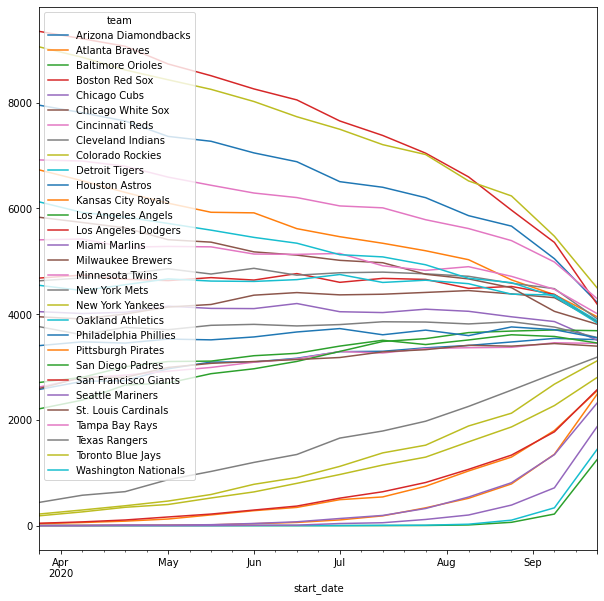

In [279]:
plot_df = playoff_df.pivot(index='start_date', columns='team', values='apps')
plot_df.plot(figsize=(10, 10))

In [280]:
playoff_odds_by_date = {}

for date in playoff_apps_by_start_date:
    playoff_odds_by_date[date.strftime("%Y-%m-%d")] = {}
    for team in playoff_apps_by_start_date[date]:
        playoff_odds_by_date[date.strftime("%Y-%m-%d")][team] = playoff_apps_by_start_date[date][team]/SEASONS_TO_SIMULATE

with open("final_odds.json",'w') as fp:
    fp.write(json.dumps(playoff_odds_by_date, indent=4))
